In [1]:
import pandas as pd

In [3]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [6]:
chunk_size = 1000000
chunks = []

for chunk in pd.read_csv('rba-dataset.csv', chunksize=chunk_size):
    chunks.append(chunk)
    print(f"Loaded chunk: {chunk.shape}")
    if len(chunks) == 1:  # Load only 1M rows for now to test
        break

data = pd.concat(chunks, axis=0)

Loaded chunk: (1000000, 16)


In [7]:
data['Login Hour'] = pd.to_datetime(data['Login Timestamp']).dt.hour
data['Is Account Takeover'] = data['Is Account Takeover'].astype(np.uint8)
data['Is Attack IP'] = data['Is Attack IP'].astype(np.uint8)
data['Login Successful'] = data['Login Successful'].astype(np.uint8)
data.drop(columns=["Round-Trip Time [ms]", 'Region', 'City', 'Login Timestamp', 'index'], inplace=True)

data['User Agent String'], _ = pd.factorize(data['User Agent String'])
data['Browser Name and Version'], _ = pd.factorize(data['Browser Name and Version'])
data['OS Name and Version'], _ = pd.factorize(data['OS Name and Version'])

# IP Conversion
def ip_to_int(ip): return int(ipaddress.ip_address(ip))
data['IP Address'] = data['IP Address'].apply(ip_to_int)


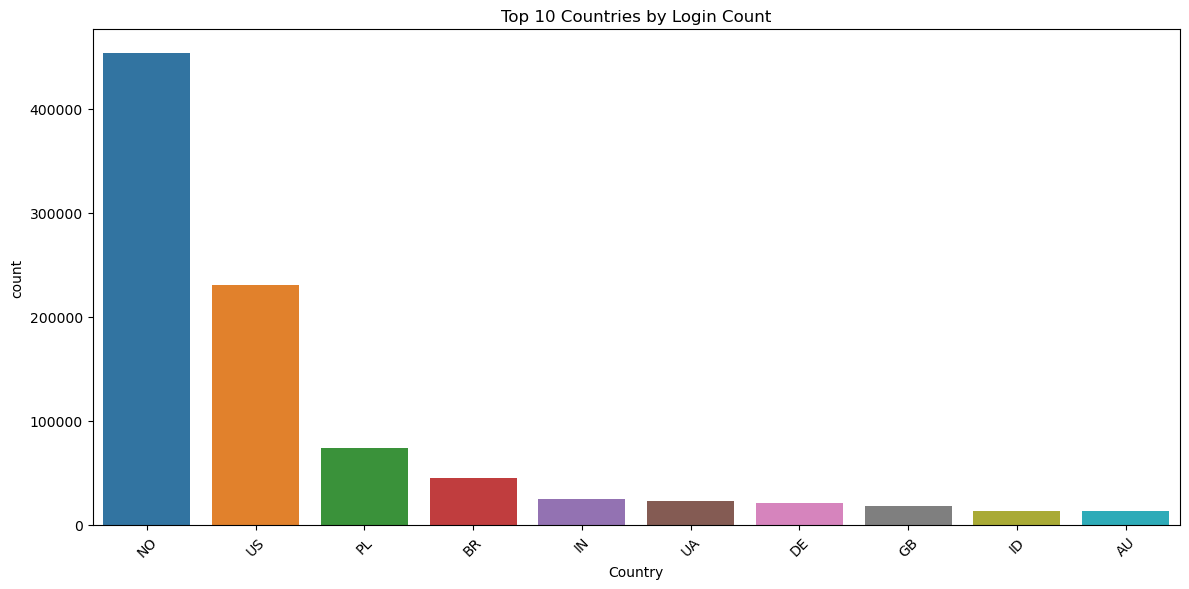

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Country', order=data['Country'].value_counts().nlargest(10).index)
plt.title('Top 10 Countries by Login Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

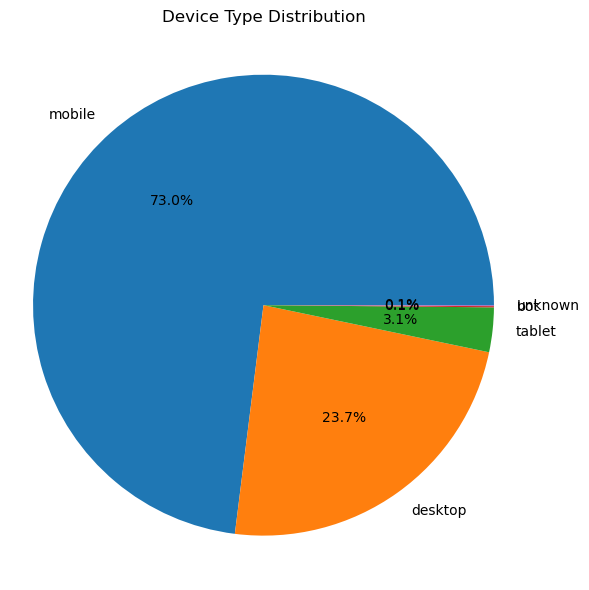

In [10]:
plt.figure(figsize=(6,6))
device_counts = data['Device Type'].value_counts()
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%')
plt.title('Device Type Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

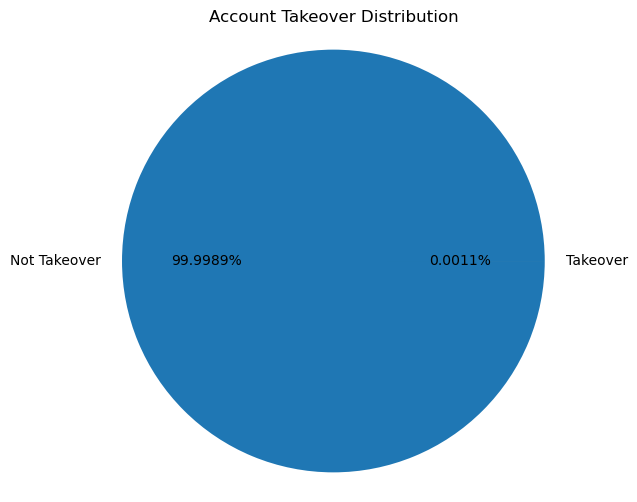

In [11]:
plt.figure(figsize=(6,6))
plt.pie(data['Is Account Takeover'].value_counts(), labels=['Not Takeover', 'Takeover'], autopct='%1.4f%%')
plt.title('Account Takeover Distribution')
plt.axis('equal')
plt.show()

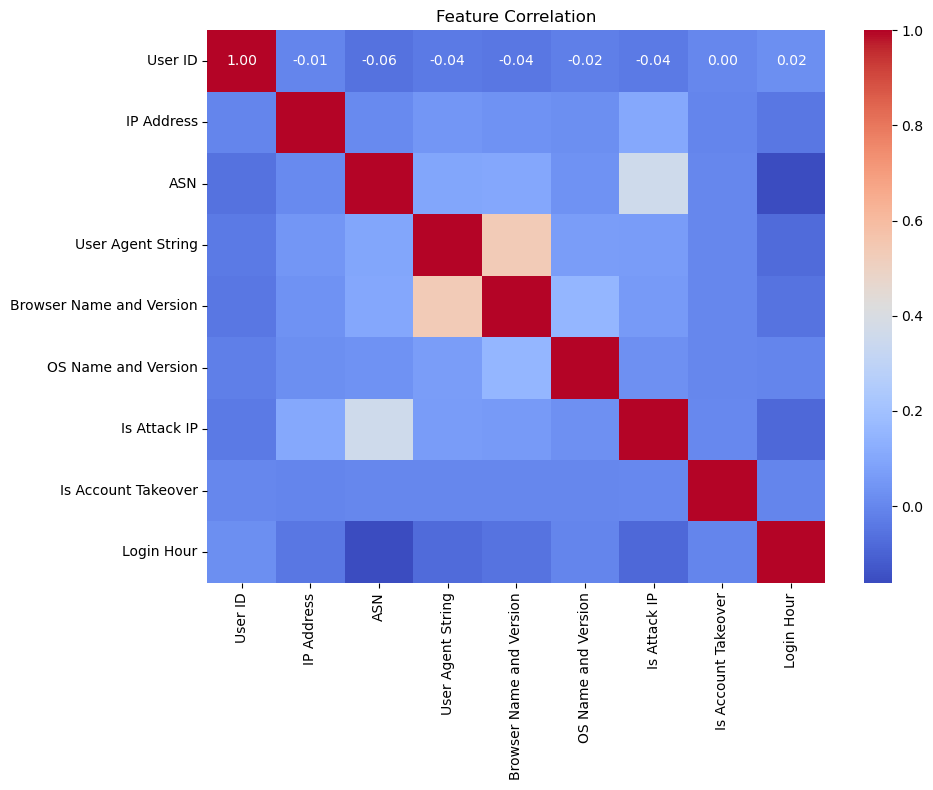

In [15]:
# Only select numeric columns before computing correlation
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation")
plt.tight_layout()
plt.show()


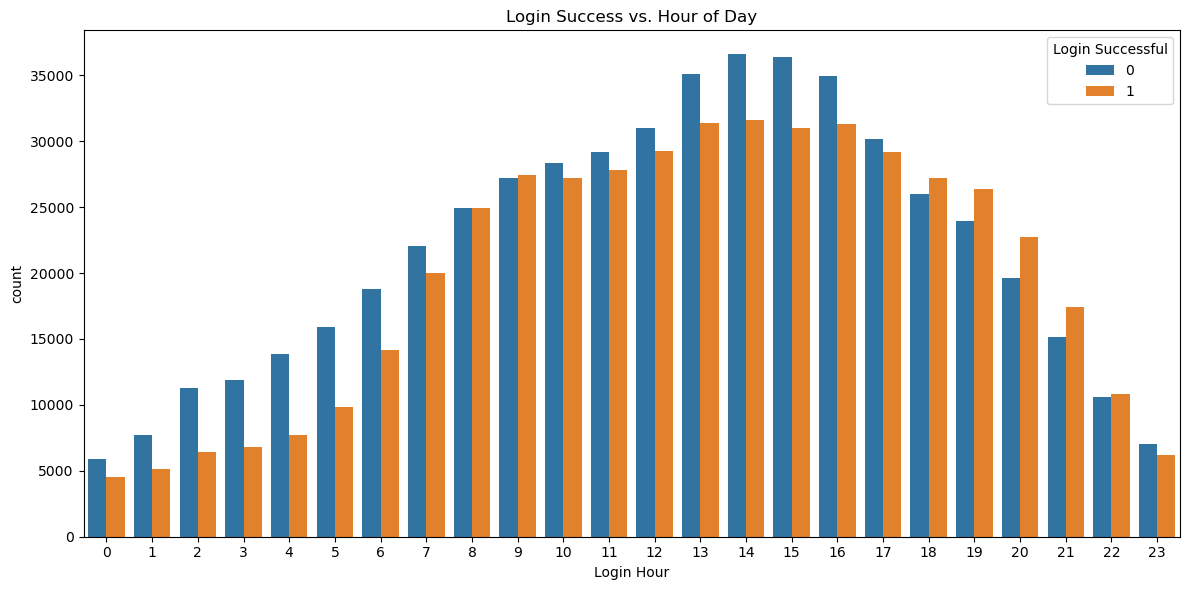

In [14]:
data['Login Successful'] = data['Login Successful'].astype(str)

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='Login Hour', hue='Login Successful')
plt.title('Login Success vs. Hour of Day')
plt.tight_layout()
plt.show()


In [16]:
categorical_cols = ['Country', 'Device Type']
numeric_cols = ['ASN', 'Login Hour', 'IP Address', 'User Agent String',
                'Browser Name and Version', 'OS Name and Version']

X = data.drop(columns=['Is Attack IP', 'Is Account Takeover'])
y = data['Is Account Takeover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [18]:
results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    results.append([name, round(acc, 4), round(auc, 4), round(precision, 4), round(recall, 4), round(f1, 4)])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'AUC Score', 'Precision (Takeover)', 'Recall (Takeover)', 'F1-Score (Takeover)'])
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [11:11:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model Performance Summary:
              Model  Accuracy  AUC Score  Precision (Takeover)  Recall (Takeover)  F1-Score (Takeover)
Logistic Regression       1.0     0.9900                   0.0                0.0                  0.0
      Decision Tree       1.0     0.5000                   0.0                0.0                  0.0
      Random Forest       1.0     0.7499                   0.0                0.0                  0.0
           AdaBoost       1.0     0.3917                   0.0                0.0                  0.0
            XGBoost       1.0     0.9267                   0.0                0.0                  0.0


In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [21]:
categorical_cols = ['Country', 'Device Type']
numeric_cols = ['ASN', 'Login Hour', 'IP Address', 'User Agent String',
                'Browser Name and Version', 'OS Name and Version']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [22]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [23]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_processed, y_train)

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000, solver='saga')
model.fit(X_resampled, y_resampled)


LogisticRegression(max_iter=2000, solver='saga')

Accuracy: 0.99845
AUC Score: 0.987989879898799

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199998
           1       0.00      0.00      0.00         2

    accuracy                           1.00    200000
   macro avg       0.50      0.50      0.50    200000
weighted avg       1.00      1.00      1.00    200000



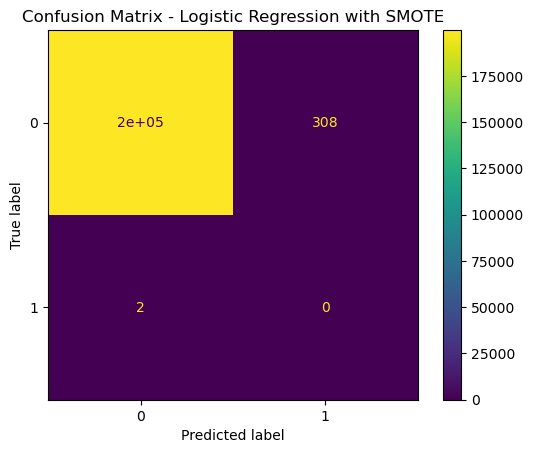

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score

# Predict on the original test set (transformed)
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test_processed, y_test)
plt.title("Confusion Matrix - Logistic Regression with SMOTE")
plt.show()


In [28]:
df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'AUC', 'Precision (Takeover)', 'Recall (Takeover)', 'F1-Score (Takeover)'
])


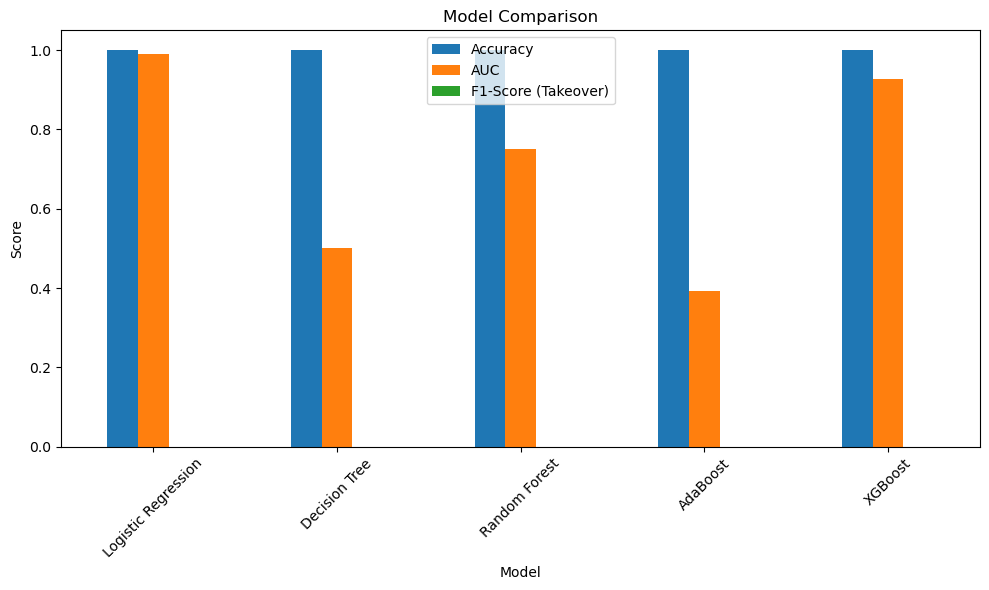

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot comparison of Accuracy, AUC, and F1
df.set_index('Model')[['Accuracy', 'AUC', 'F1-Score (Takeover)']].plot(kind='bar', figsize=(10,6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [33]:
df['Login Hour'] = pd.to_datetime(df.index).hour


In [15]:
#Import The Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import ipaddress

In [16]:
#Load The Dataset
data = pd.read_csv('rba-dataset.csv', nrows=1000000)


In [17]:
#Data Preprocessing/Cleaning
#Calculating The Exact Hour of Day
data['Login Hour'] = pd.to_datetime(data['Login Timestamp']).dt.hour


In [18]:
#Converting Booleans To Integers
data['Is Account Takeover'] = data['Is Account Takeover'].astype(np.uint8)
data['Is Attack IP'] = data['Is Attack IP'].astype(np.uint8)
data['Login Successful'] = data['Login Successful'].astype(np.uint8)

In [19]:
#Dropping Unneeded Columns
data = data.drop(columns=["Round-Trip Time [ms]", 'Region', 'City', 'Login Timestamp', 'index'])

In [20]:
#Converting Strings To Integers
data['User Agent String'], _ = pd.factorize(data['User Agent String'])
data['Browser Name and Version'], _ = pd.factorize(data['Browser Name and Version'])
data['OS Name and Version'], _ = pd.factorize(data['OS Name and Version'])

In [21]:
#Converting IP Addresses To Integers
def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

data['IP Address'] = data['IP Address'].apply(ip_to_int)

In [22]:
#Encoding Categorical & Numerical Variables
categorical_cols = ['Country', 'Device Type']
numeric_cols = ['ASN', 'Login Hour', 'IP Address', 'User Agent String', 'Browser Name and Version', 'OS Name and Version']

In [9]:
# Splitting the dataset
features = data.drop(['Is Attack IP', 'Is Account Takeover'], axis=1)
labels = data['Is Account Takeover']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [23]:
#Training The Model
#Preparing The Pipeline
# Preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Classifiers
classifiers = {
    'logistic_regression': LogisticRegression(max_iter=1000),
    'decision_tree': DecisionTreeClassifier(),
    'svm': SVC(probability=True),
    'random_forest': RandomForestClassifier()
}

# A function to choose classifiers
def make_pipeline(classifier_key):
    if classifier_key in classifiers:
        clf = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifiers[classifier_key])
        ])
        return clf
    else:
        raise ValueError(f"Classifier {classifier_key} is not defined")

In [24]:
#Logistic Regression
classifier_key = 'logistic_regression'
pipeline = make_pipeline(classifier_key)
pipeline.fit(X_train, y_train)

# Evaluation
predictions = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probs)

print(f"AUC Score: {auc_score}")

AUC Score: 0.916850419422958


In [25]:
#Decision Trees
classifier_key = 'decision_tree'
pipeline = make_pipeline(classifier_key)
pipeline.fit(X_train, y_train)

# Evaluation
predictions = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probs)

print(f"AUC Score: {auc_score}")

AUC Score: 0.8333308332958327


In [26]:
#Support Vector Machines (SVMs)
classifier_key = 'svm'
pipeline = make_pipeline(classifier_key)
pipeline.fit(X_train, y_train)

# Evaluation
predictions = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probs)

print(f"AUC Score: {auc_score}")

AUC Score: 0.9879314856389512


In [27]:
#Random Forest
classifier_key = 'random_forest'
pipeline = make_pipeline(classifier_key)
pipeline.fit(X_train, y_train)

# Evaluation
predictions = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probs)

print(f"AUC Score: {auc_score}")

AUC Score: 0.8333033328833266
